# Moder Neural Network
This notebook will mainly focus how data passed in NN. It is often confusing for morden NN in terms of the shape of data: instead of $\mathbb{R}^2$, vectors are often in $\mathbb{R}^3$ or even $\mathbb{R}^4$. The reason behind this is that people want to create bigger matrices to multiply together rather than multipling matrices a couple of times, which is desirable for parallelism.  

Takeaway:
- RNN and LSTM both use the hidden state $H$ passing through a FCL as their output: $Y = H_t W_{hq} + b_q$. Their difference is just how to update $H$. 


In [ ]:
!pip install d2l==0.17.0

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
# load natural language data (the book "time machine")
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
len(vocab)

28

`vocab` is a dictionary/vocabulary list, which stores the index pair of each word/character(depending on how you create it), where the pair is stored by the descending order of frequency. 


## RNN

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

Now we need to manually initialize the hidden state, since at time $t$ passing through a RNN layer needs $H_{t-1}$ and $X_t$ to get $H_t$.

In [ ]:
# create a zero vector as the hidden state
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [ ]:
# see the shape of data
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [ ]:
class RNNModel:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Y.shape = (number_of_steps, batch_size, number_of_hidden_units), where the number of hidden units can be thought as the dimension of output, which can then be passed into a fully-connected layer (needs to be reshaped as (number_of_steps $\times$ batch_size, number_of_hidden_units) a two dimensional matrix).

## GRN (Gated Recurrent Units)
A simplified version of LSTM, but not provided in Pytorch for now?

## LSTM
There are two state/gates that will be passed into the next time step: $H_t$ and $C_t$, where $C_t$ is not computed through an activation function ($tanh$ for example). Thus, the range of $C_t$ can be bigger than $H_t$ and so memorize more information. 

perplexity 10.1, 15879.6 tokens/sec on cpu
time traveller an the the the the the the the the the the the th
traveller an the the the the the the the the the the the th


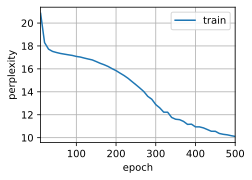

In [ ]:
num_inputs = len(vocab)
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))


# train 
lr = 1e-1
num_epochs = 500
device = d2l.try_gpu()
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

Deep LSTM by just adding the number of layers

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

## Bidirectional RNN
- Unable to predict future
- Use the whole existing line to train
- Often used to classify texts or translation by giving the full text.

In [ ]:
# Define the bidirectional LSTM model by setting `bidirectional=True`
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))

## Encoder-Decoder
It is an NN with Two blocks:

Encoder:
- Input: a minibatch of datasets
- Output: an output and a hidden state created by RNN  

Decoder:
- Input: When training, we concatenate the training label with the output of the Encoder as the input. At the same time, the RNN in Decoder has the same structure as the input and its hidden state is initialized by the hidden state passed from the Encoder. 
- Output: Desired output for a minibatch (often it is a probability vector on each label)


## Attension Mechanism
There are 3 key elements:

- queries: (batch size, number of queries, query size)
- keys: (batch size, number of key-value pairs, key size)
- values: (batch size, number of key-value pairs, feature value size)

,where `queries` and `keys` are used to calculate the weight of the weighted sum over all `values`, where the weight is also called 'Attension Score'.

Mathematically, if $\mathbf{q}$ is the query and $\mathbf{k}_i$ is the key-value pair, then $\alpha(\mathbf{q}, \mathbf{k}_i)$ is the 'Attension Score' and $f$ is called **attension pooling**:
$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v.$$

Or, if you think $\mathbf{q}\in \mathbb{R}^q \rightarrow f(\mathbf{q}) \in \mathbb{R}^v$ in this way, then it is actually a linear projection on a batch of queries from $\mathbb{R}^q$ to $\mathbb{R}^v$.

In general, no matter how we define the scoring function(how to calculate the weights for each key-value pair), in the end, we need to do batch matrix multiplication (like `torch.bmm(self.dropout(self.attention_weights), values)`).


In [ ]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # Here queires is 3-dimensional, and W_q is 2-dimensional. They multiply 
        # together by broadcasting rule. 
        print(queries.shape, keys.shape)
        queries, keys = self.W_q(queries), self.W_k(keys)
        print(queries.shape, keys.shape)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        # print("quries:\n",queries)
        # print("keys:\n", keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # print(features)
        print(features.shape)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        print("attension weights shape", self.attention_weights.shape)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

### Attension Mechanism application
Attension is just a layer like FCL and so It can combine with other layers. 
- Combine with RNN (https://d2l.ai/chapter_attention-mechanisms/bahdanau-attention.html)


### Multi-Head Attention
The multi-head attention output
is just a bunch of attension concatenated together via 
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads (one head is an attension poolling $\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v}$ as we define above):

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

## Transformer
Transformer is a popular model nowadays. To understand it, we need the knowledge of Encoder-Decoder.
### Encoder-Decoder
Instead of data passing from layers to layers sequetially, Encoder-Decoder uses a different structure.

#### [RNN-Encoder-Decoder](https://d2l.ai/chapter_recurrent-modern/seq2seq.html)

In RNN-Encoder-Decoder, we pass the last hidden state of all RNN layers into the decoder's RNN layers as their initial state (so we need to assume they have the same of RNN layers and the same hidden units).

#### [Transformer](https://d2l.ai/chapter_attention-mechanisms/transformer.html), 

In Transformer, both encoder and decoder are a bunch of stacked blocks, where each decoder block is composed of a 'Self multi-head Attension', an 'Encoder-decoder attention' and a PositionWise feed-forward network. 
- 'Self multi-head Attension' will use input as queries, keys and values (only for trainning, but prediction is different.).

- 'Encoder-decoder attention': we pass the encoder output as the keys and values of each decoder block's 'Encoder-decoder attention' and the output of the last attention layer ('Self multi-head Attension') as its queries.

### [BERT](https://d2l.ai/chapter_natural-language-processing-pretraining/bert.html)
The first deep/large NLP models has a good performance based on the Encoder of Transformer. It has also been shown good on transfer learning(using a pre-trained large model to fine-tuning a specific project). 

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments